In [1]:
import pandas as pd
from scipy.stats import norm, ttest_ind, levene, bartlett
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 9)

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
try:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv', index_col=0)
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

In [3]:
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


`tariff_name` — название тарифа  
`rub_monthly_fee` — ежемесячная абонентская плата в рублях  
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату  
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату  
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета  
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [4]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


`user_id` — уникальный идентификатор пользователя  
`first_name` — имя пользователя  
`last_name` — фамилия пользователя  
`age` — возраст пользователя (годы)  
`reg_date` — дата подключения тарифа (день, месяц, год)  
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
`city` — город проживания пользователя  
`tariff` — название тарифного плана  

In [5]:
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


`id` — уникальный номер звонка  
`call_date` — дата звонка  
`duration` — длительность звонка в минутах  
`user_id` — идентификатор пользователя, сделавшего звонок  

In [6]:
display(internet.head(2))
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


`id` — уникальный номер сессии  
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)  
`session_date` — дата интернет-сессии  
`user_id` — идентификатор пользователя  

In [7]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


`id` — уникальный номер сообщения  
`message_date` — дата сообщения  
`user_id` — идентификатор пользователя, отправившего сообщение

В данных нет пропусков за исключением `churn_date`. Пропуски здесь означают, что клиент не отказался от своего тарифа на момент сбора данных.

# Шаг 2. Подготовьте данные

- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных, если они есть

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

## Приведение типов данных

Даты во всех датасетах нужно привести к типу `datetime`.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

## Ошибки

### Users

Сперва проверим на соответствие здравому смыслу (нет отрицательного возраста и дат подключения раньше изобретения телефона).

In [9]:
users.describe(datetime_is_numeric=True)

,user_id,age,churn_date,reg_date
count,500.000000,500.00000,38,500
mean,1249.500000,46.58800,2018-11-13 00:37:53.684210432,2018-06-30 18:57:35.999999744
min,1000.000000,18.00000,2018-08-17 00:00:00,2018-01-01 00:00:00
25%,1124.750000,32.00000,2018-10-14 00:00:00,2018-04-07 12:00:00
50%,1249.500000,46.00000,2018-11-24 00:00:00,2018-07-02 12:00:00
75%,1374.250000,62.00000,2018-12-15 12:00:00,2018-09-29 00:00:00
max,1499.000000,75.00000,2018-12-30 00:00:00,2018-12-31 00:00:00
std,144.481833,16.66763,NaN,NaN


In [10]:
(
    users
    .select_dtypes(include='O')
    .describe()
)

,city,first_name,last_name,tariff
count,500,500,500,500
unique,76,246,419,2
top,Москва,Радим,Андреенко,smart
freq,99,6,5,351


Проверим на наличие дубликатов.

In [11]:
users.duplicated().sum()

0

Проверим на уникальность значения столбца `user_id`

In [12]:
users['user_id'].nunique() == len(users)

True

### Calls

Аналогичные проверки.

In [13]:
calls.describe(datetime_is_numeric=True)

,call_date,duration,user_id
count,202607,202607.000000,202607.000000
mean,2018-09-02 20:01:37.583992832,6.755887,1253.940619
min,2018-01-01 00:00:00,0.000000,1000.000000
25%,2018-07-05 00:00:00,1.300000,1126.000000
50%,2018-09-17 00:00:00,6.000000,1260.000000
75%,2018-11-14 00:00:00,10.700000,1379.000000
max,2018-12-31 00:00:00,38.000000,1499.000000
std,NaN,5.843365,144.722751


In [14]:
(
    calls
    .select_dtypes(include='O')
    .describe()
)

,id
count,202607
unique,202607
top,1000_0
freq,1


In [15]:
calls.duplicated().sum()

0

Проверим, для всех ли аббонентов имеется информация о звонках. Рассмотрим аббонентов, которые не совершали звонки, если такие есть.

In [16]:
users[users['user_id'].isin(set(users['user_id']) - set(calls['user_id']))]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
91,1091,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra
106,1106,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
231,1231,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra
328,1328,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart
473,1473,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra
489,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


Двое из них отключили тариф почти сразу после подключения: возможно, они просто не успели никому позвонить. Остальные, видимо, просто не используют телефон для звонков.

### Internet

In [17]:
internet.describe(datetime_is_numeric=True)

,mb_used,session_date,user_id
count,149396.000000,149396,149396.000000
mean,370.192426,2018-09-02 12:55:35.221826560,1252.099842
min,0.000000,2018-01-01 00:00:00,1000.000000
25%,138.187500,2018-07-05 00:00:00,1130.000000
50%,348.015000,2018-09-17 00:00:00,1251.000000
75%,559.552500,2018-11-14 00:00:00,1380.000000
max,1724.830000,2018-12-31 00:00:00,1499.000000
std,278.300951,NaN,144.050823


In [18]:
(
    internet
    .select_dtypes(include='O')
    .describe()
)

,id
count,149396
unique,149396
top,1000_0
freq,1


In [19]:
internet.duplicated().sum()

0

In [20]:
users[users['user_id'].isin(set(users['user_id']) - set(internet['user_id']))]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
273,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Те же двое, кто почти сразу отключили тариф и Рэм Корнилов из Кругана.

### Messages

In [21]:
messages.describe(datetime_is_numeric=True)

,message_date,user_id
count,123036,123036.000000
mean,2018-09-04 15:28:42.227640576,1256.989410
min,2018-01-02 00:00:00,1000.000000
25%,2018-07-09 00:00:00,1134.000000
50%,2018-09-20 00:00:00,1271.000000
75%,2018-11-14 00:00:00,1381.000000
max,2018-12-31 00:00:00,1499.000000
std,NaN,143.523967


In [22]:
messages.duplicated().sum()

0

In [23]:
users[users['user_id'].isin(set(users['user_id']) - set(messages['user_id']))]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
10,1010,26,NaT,Тюмень,Эдуард,Кононов,2018-08-05,smart
17,1017,73,NaT,Краснодар,Мария,Аленникова,2018-05-22,smart
24,1024,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra
...,...,...,...,...,...,...,...,...
462,1462,72,NaT,Тольятти,Алёна,Абрамычева,2018-10-29,smart
466,1466,37,NaT,Новосибирск,Рубен,Шевцов,2018-02-28,ultra
469,1469,41,NaT,Сочи,Аксён,Абалкин,2018-07-06,ultra
479,1479,40,NaT,Хабаровск,Игорь,Богданов,2018-07-03,smart


Проблем в данных не обнаружено.
Приступим к созданию таблиц с дополнительной информацией.

## Звонки и минуты по месяцам

Для удобства создадим столбец `month`, содержащий месяц совершения звонка.
Поскольку в датасете звонки только за 2018 год, уникальных значений этого столбца будет всего 12.

In [24]:
calls['month'] = calls['call_date'].astype('datetime64[M]')

call_count_by_month = calls.pivot_table(values='id',
                                        columns='month',
                                        index='user_id',
                                        aggfunc='count',
                                        fill_value=0)
call_count_by_month.head()

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
user_id,,,,,,,,,,,,
1000,0,0,0,0,22,43,47,52,58,57,43,46
1001,0,0,0,0,0,0,0,0,0,0,59,63
1002,0,0,0,0,0,15,26,42,36,33,32,33
1003,0,0,0,0,0,0,0,55,134,108,115,108
1004,0,0,0,0,9,31,22,19,26,29,19,21


Вспомним, что "Мегалайн" округляет секунды до минут в каждом отдельном звонке. Поэтому необходимо округлить `duration` до того как собрать сводную таблицу.

In [25]:
calls['duration'] = np.ceil(calls['duration'])

call_duration_by_month = calls.pivot_table(values='duration',
                                           columns='month',
                                           index='user_id',
                                           aggfunc='sum',
                                           fill_value=0)
call_duration_by_month.head()

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
user_id,,,,,,,,,,,,
1000,0,0,0,0,159,172,340,408,466,350,338,333
1001,0,0,0,0,0,0,0,0,0,0,430,414
1002,0,0,0,0,0,117,214,289,206,212,243,236
1003,0,0,0,0,0,0,0,380,961,855,824,802
1004,0,0,0,0,35,171,135,137,117,145,117,130


## Сообщения по месяцам

In [26]:
messages['month'] = messages['message_date'].astype('datetime64[M]')

msg_count_by_month = messages.pivot_table(values='id',
                                          columns='month',
                                          index='user_id',
                                          aggfunc='count',
                                          fill_value=0)
msg_count_by_month.head()

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
user_id,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70
1002,0,0,0,0,0,4,11,13,4,10,16,12
1003,0,0,0,0,0,0,0,37,91,83,94,75
1004,0,0,0,0,95,134,181,151,146,165,158,162
1005,7,38,56,41,42,47,56,64,52,44,51,54


## Объем трафика по месяцам

Трафик по правилам компании округляется в конце месяца, а не по результатам каждой сессии. Поэтому сейчас округлять ничего не нужно.

In [27]:
internet['month'] = internet['session_date'].astype('datetime64[M]')

internet_sum_by_month = internet.pivot_table(values='mb_used',
                                             columns='month',
                                             index='user_id',
                                             aggfunc='sum',
                                             fill_value=0)
internet_sum_by_month.head()

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1001,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,18429.34,14036.66
1002,0.0,0.0,0.0,0.0,0.00,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
1003,0.0,0.0,0.0,0.0,0.00,0.00,0.00,8565.21,12468.87,14768.14,11356.89,10121.53
1004,0.0,0.0,0.0,0.0,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04


## Помесячная выручка

- Округлим Мб согласно правилам компании;
- Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
- Остаток умножим на значение из тарифного плана;
- Прибавим абонентскую плату, соответствующую тарифному плану.

In [28]:
# для удобства обращения
tariffs.index = tariffs['tariff_name'].values

try:
    tariffs.drop(columns='tariff_name',
                 inplace=True)
except:
    pass

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


In [29]:
def mb_ceil_to_gb(val):
    """
    Округляет val до гигабайтов в большую сторону.
    Возвращает количество гигабайт.
    """
    if val % 1024 != 0:
        return (val + 1024 - val % 1024) / 1024
    return val / 1024


def calculate_revenue(user):
    """
    Считает выручку за каждый месяц для пользователя user
    Возвращает Series, в которых индекс - номер месяца, значение - суммарная выручка в этом месяце
    """
    result = {x: 0 for x in range(1, 13)}
    user_tariff = tariffs.loc[user['tariff']]
    for i in range(1, 13):
        month_sum = 0
        if i < user['reg_month'].month:
            result[i] = month_sum
            continue
        month_sum = (np.clip(user.iloc[2 + i] - user_tariff['minutes_included'], 0, None) * user_tariff['rub_per_minute'] +
                     np.clip(user.iloc[2 + i + 12] - user_tariff['messages_included'], 0, None) * user_tariff['rub_per_minute'] +
                     np.clip(user.iloc[2 + i + 24] - user_tariff['gb_per_month_included'], 0, None) * user_tariff['rub_per_gb'] +
                     user_tariff['rub_monthly_fee'])
        # month_sum = (max(0, user.iloc[2 + i] - user_tariff['minutes_included']) * user_tariff['rub_per_minute'] +
        #              max(0, user.iloc[2 + i + 12] - user_tariff['messages_included']) * user_tariff['rub_per_message'] +
        #              max(0, user.iloc[2 + i + 24] - user_tariff['gb_per_month_included']) * user_tariff['rub_per_gb'] +
        #              user_tariff['rub_monthly_fee'])
        result[i] = month_sum
    return pd.Series(result)

In [30]:
# округление трафика
internet_sum_by_month = internet_sum_by_month.applymap(mb_ceil_to_gb)

In [31]:
# вспомогательные столбцы
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')
users['reg_month'] = users['reg_date'].astype('datetime64[M]')

# создание таблицы для проведения расчета выручки
users_calls_msg_inet_union = (
    users[['user_id', 'reg_month', 'tariff']]
    .join(call_duration_by_month,
          on='user_id',
          how='left')
)

users_calls_msg_inet_union = (
    users_calls_msg_inet_union
    .join(msg_count_by_month,
          on='user_id',
          how='left',
          rsuffix='_msg')
)

users_calls_msg_inet_union = (
    users_calls_msg_inet_union
    .join(internet_sum_by_month,
          on='user_id',
          how='left',
          rsuffix='_inet')
    .fillna(0)
)

users_calls_msg_inet_union.head()

,user_id,reg_month,tariff,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,...,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00
0,1000,2018-05-01,ultra,0.0,0.0,0.0,0.0,159.0,172.0,340.0,...,0.0,0.0,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0
1,1001,2018-11-01,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0
2,1002,2018-06-01,smart,0.0,0.0,0.0,0.0,0.0,117.0,214.0,...,0.0,0.0,0.0,11.0,18.0,20.0,17.0,14.0,19.0,18.0
3,1003,2018-08-01,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,13.0,15.0,12.0,10.0
4,1004,2018-05-01,ultra,0.0,0.0,0.0,0.0,35.0,171.0,135.0,...,0.0,0.0,14.0,18.0,22.0,28.0,15.0,19.0,16.0,18.0


Составим сводную таблицу с помесячной выручкой с каждого пользователя.

In [32]:
users_revenue = (
    users_calls_msg_inet_union[['user_id', 'tariff']]
    .join(users_calls_msg_inet_union
          .apply(calculate_revenue,
                 axis=1))
)

users_revenue.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0
2,1002,smart,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
4,1004,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0


# Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Расчет средних, дисперсии и СКО

Рассчитаем среднее количество минут разговора, смс и интернет трафика для каждого пользователя с учетом их месяца подключения. Также рас

In [33]:
users_calls = (
    users[['user_id', 'reg_month', 'tariff']]
    .join(call_duration_by_month,
          on='user_id',
          how='left')
    .fillna(0)
)
users_calls['mean'] = users_calls.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].mean(), axis=1)
users_calls['sigma2'] = users_calls.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0)**2, axis=1)
users_calls['sigma'] = users_calls.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0), axis=1)

users_msg = (
    users[['user_id', 'reg_month', 'tariff']]
    .join(msg_count_by_month,
          on='user_id',
          how='left').
    fillna(0)
)
users_msg['mean'] = users_msg.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].mean(), axis=1)
users_msg['sigma2'] = users_msg.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0)**2, axis=1)
users_msg['sigma'] = users_msg.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0), axis=1)

users_inet = (
    users[['user_id', 'reg_month', 'tariff']]
    .join(internet_sum_by_month,
          on='user_id',
          how='left')
    .fillna(0)
)
users_inet['mean'] = users_inet.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].mean(), axis=1)
users_inet['sigma2'] = users_inet.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0)**2, axis=1)
users_inet['sigma'] = users_inet.apply(lambda x: x.iloc[x['reg_month'].month + 2:15].std(ddof=0), axis=1)

display(users_calls.head(2))
display(users_msg.head(2))
display(users_inet.head(2))

,user_id,reg_month,tariff,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,mean,sigma2,sigma
0,1000,2018-05-01,ultra,0.0,0.0,0.0,0.0,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,320.75,9834.1875,99.167472
1,1001,2018-11-01,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,414.0,422.00,64.0000,8.000000


,user_id,reg_month,tariff,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,mean,sigma2,sigma
0,1000,2018-05-01,ultra,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,62.0,295.0,17.175564
1,1001,2018-11-01,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


,user_id,reg_month,tariff,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,mean,sigma2,sigma
0,1000,2018-05-01,ultra,0.0,0.0,0.0,0.0,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0,13.625,27.484375,5.242554
1,1001,2018-11-01,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,16.000,4.000000,2.000000


### Распеределения средних

#### Звонки

Построим гистограммы распределения средних значений, покажем стандартное отклонение и квартили для более подробного понимания.
Отдельно рассмотрим какая доля пользователей тратят не больше минут, чем включено в их тариф.

Доля пользователей тарифа smart, которые тратят в месяц не более включенного количества минут:
71.40%
Доля пользователей тарифа ultra, которые тратят в месяц не более включенного количества минут:
100.00%


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,351.0,415.784481,149.025721,0.0,310.666667,423.3,518.616667,891.500000
ultra,149.0,518.012821,287.981263,0.0,301.166667,512.1,746.333333,1179.363636


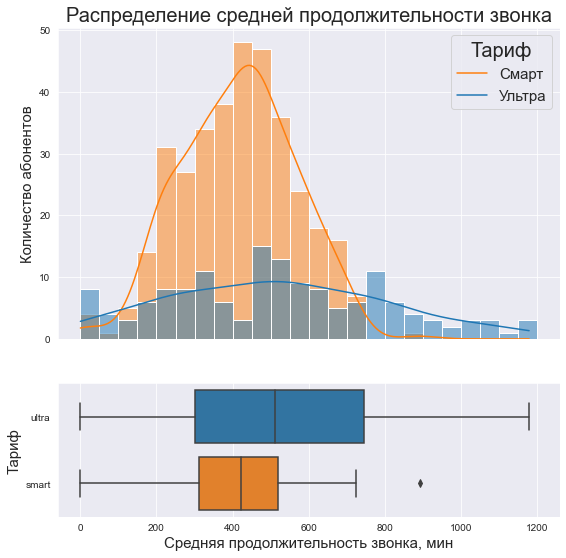

In [34]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.70, .30)})

sns.histplot(data=users_calls, x='mean', hue='tariff', kde=True, binwidth=50, ax=ax_hist)
ax_hist.legend(['Смарт', 'Ультра'], title='Тариф', fontsize='15')
ax_hist.set_title('Распределение средней продолжительности звонка', fontsize=20)
ax_hist.set_ylabel('Количество абонентов', fontsize=15)
plt.setp(ax_hist.get_legend().get_title(), fontsize='20')

sns.boxplot(data=users_calls, x='mean', y='tariff', ax=ax_box)
ax_box.set_xlabel('Средняя продолжительность звонка, мин', fontsize=15)
ax_box.set_ylabel('Тариф', fontsize=15)

calls_mean_desc = users_calls.groupby('tariff')['mean'].describe()

for tariff in calls_mean_desc.index:
    print(f"Доля пользователей тарифа {tariff}, которые тратят в месяц не более включенного количества минут:")
    print(f"{norm(calls_mean_desc.loc[tariff, 'mean'], calls_mean_desc.loc[tariff, 'std']).cdf(tariffs.loc[tariff, 'minutes_included']):.2%}")

display(calls_mean_desc)

**ВЫВОДЫ:**
Тариф Smart:
- Средние распределены нормально, что соответствует ЦПТ.
- В среднем пользователю тарифа "smart" требуется 415 минут разговора в месяц.
- 520 минут в среднем хватает более чем 75% пользователей.
- 71,4% не выходят за рамки тарифа.

Тариф Ultra:
- Аналогично тарифу Smart, средние распределены нормально, но имеют большую дисперсию, что объясняется малым количеством пользователей в выборке.
- В среднем пользователь тарифа Ultra тратит 518 минут разговора в месяц, что лишь немного превышает лимит более дешевого тарифа Smart и не превышает лимит тарифа Ultra.
- 746 минут разговора хватает для 75% пользователей.
- 100% пользователей не выходят за свой лимит в 3000 минут в месяц.

#### СМС

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,351.0,32.012986,26.520553,0.0,11.0,27.0,48.0,118.0
ultra,149.0,53.147225,46.488956,0.0,14.0,44.0,82.0,192.0


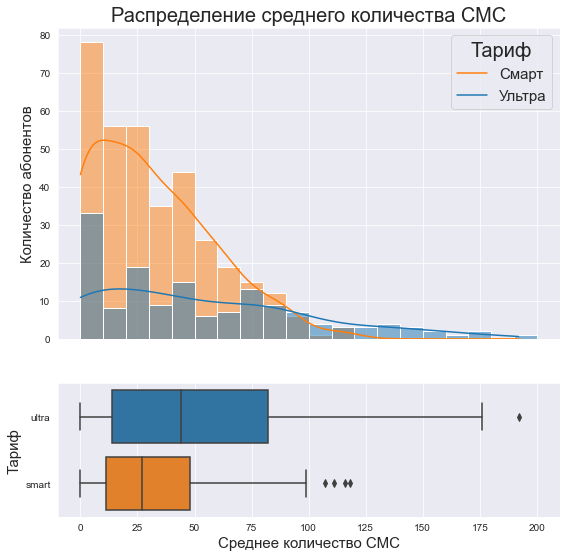

In [35]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.70, .30)})

sns.histplot(data=users_msg, x='mean', hue='tariff', kde=True, binwidth=10, ax=ax_hist)
ax_hist.legend(['Смарт', 'Ультра'], title='Тариф', fontsize='15')
ax_hist.set_title('Распределение среднего количества СМС', fontsize=20)
ax_hist.set_ylabel('Количество абонентов', fontsize=15)
plt.setp(ax_hist.get_legend().get_title(), fontsize='20')

sns.boxplot(data=users_msg, x='mean', y='tariff', ax=ax_box)
ax_box.set_xlabel('Среднее количество СМС', fontsize=15)
ax_box.set_ylabel('Тариф', fontsize=15)


display(users_msg.groupby('tariff')['mean'].describe())

**ВЫВОДЫ:**
Тариф Smart:
- Распределение среднего количества СМС напоминает нормальное с "отрезанным" левым хвостом. Также о смещении влево свидетельствует тот факт, что медиана меньше среднего.
- В среднем пользователям нужно 32 СМС в месяц.
- 48 СМС достаточно для 75% процентов пользователей.
- Следовательно, около 25% выходят за рамки тарифа.

Тариф Ultra:
- Распределение аналогично влево.
- В среднем абонентам нужно 53 СМС.
- 82 СМС хватает для 75% пользователей.
- За пределы тарифа пользователи не выходят.

#### Интернет

Доля пользователей тарифа smart, которые тратят в месяц не более включенного количества Гб:
38.01%
Доля пользователей тарифа ultra, которые тратят в месяц не более включенного количества Гб:
90.48%


,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,351.0,16.134628,3.716157,0.0,13.777778,16.200000,18.666667,27.25
ultra,149.0,19.146939,8.287418,0.0,13.500000,18.333333,25.400000,38.50


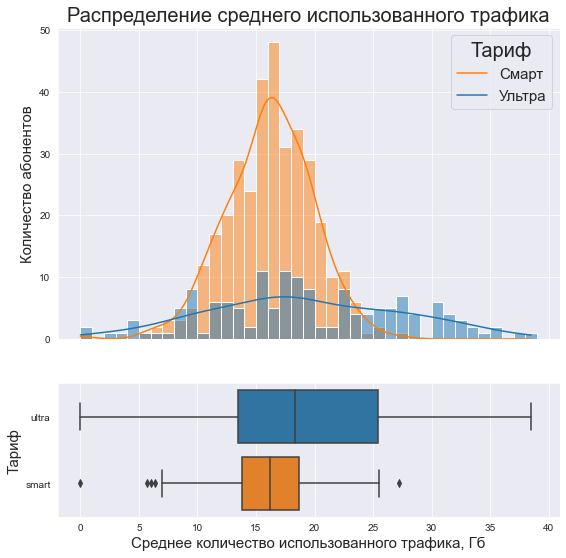

In [36]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.70, .30)})

sns.histplot(data=users_inet, x='mean', hue='tariff', kde=True, binwidth=1, ax=ax_hist)
ax_hist.legend(['Смарт', 'Ультра'], title='Тариф', fontsize='15')
ax_hist.set_title('Распределение среднего использованного трафика', fontsize=20)
ax_hist.set_ylabel('Количество абонентов', fontsize=15)
plt.setp(ax_hist.get_legend().get_title(), fontsize='20')

sns.boxplot(data=users_inet, x='mean', y='tariff', ax=ax_box)
ax_box.set_xlabel('Среднее количество использованного трафика, Гб', fontsize=15)
ax_box.set_ylabel('Тариф', fontsize=15)

inet_mean_desc = users_inet.groupby('tariff')['mean'].describe()

for tariff in inet_mean_desc.index:
    print(f"Доля пользователей тарифа {tariff}, которые тратят в месяц не более включенного количества Гб:")
    print(f"{norm(inet_mean_desc.loc[tariff, 'mean'], inet_mean_desc.loc[tariff, 'std']).cdf(tariffs.loc[tariff, 'gb_per_month_included']):.2%}")

display(inet_mean_desc)

**ВЫВОДЫ:**
Тариф Smart:
- Нормальное распределение средних значений использованного трафика.
- В среднем пользователи этого тарифа тратят 16 Гб интернета в месяц, что превышает их месячный лимит.
- 19 Гб достаточно для более чем 75% абонентов.
- Лишь 38,01% не расходуют свой интернет-трафик целиком.

Тариф Ultra:
- Значения распределены нормально, достаточно большой разброс из-за сравнительно малого количества пользователей с этим тарифом в выборке.
- В среднем людям с этим тарифом хватает 19 Гб трафика.
- 75% пользователей удовлетворены 25 Гб.
- Более 30 Гб (лимит по данному тарифу) тратят менее 10% абонентов.

# Шаг 4. Проверьте гипотезы

Гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.

Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Для проверки применим t-тест на равенство средних двух генеральных совокупностей.
Тест может быть применен, потому что:
1) Генеральные совокупности не зависят друг от друга: абоненты пользуются услугами провайдера независимо друг от друга.
2) Выборочные средние распределены нормально. Это следует из Центральной Предельной Теоремы.
3) Дисперсии генеральных совокупностей равны. Не обладая самими ГС, мы не можем гарантировать выполнение этого условия. На практике t-тест считается подходящим для проверки, если выборки достаточно большие и равны по размеру между собой.

## Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


In [37]:
users_revenue_test1 = users[['user_id', 'reg_month']].merge(users_revenue, on='user_id', how='left')
users_revenue_test1['mean'] = users_revenue_test1.apply(lambda x: x.iloc[x['reg_month'].month + 2:].mean(), axis=1)

users_revenue_test1.head(2)

,user_id,reg_month,tariff,1,2,3,4,5,6,7,8,9,10,11,12,mean
0,1000,2018-05-01,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,2018-11-01,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0,850.0


Сформулируем нулевую H_0 и альтернативную гипотезы H1:
H_0: Средняя выручка пользователей тарифа "Смарт" равна средней выручке пользоватей тарифа Ультра. mu_s == mu_u
H_1: Средняя выручка пользователей тарифа "Смарт" ***не*** равна средней выручке пользоватей тарифа Ультра. mu_s != mu_u
Пороговое значение alpha примем равным 5%.

p-value = 8.3061667871314e-16
Согласно тесту Левене дисперсии выборок не равны

p-value = 3.86328154952228e-18
Согласно тесту Бартлетта дисперсии выборок не равны


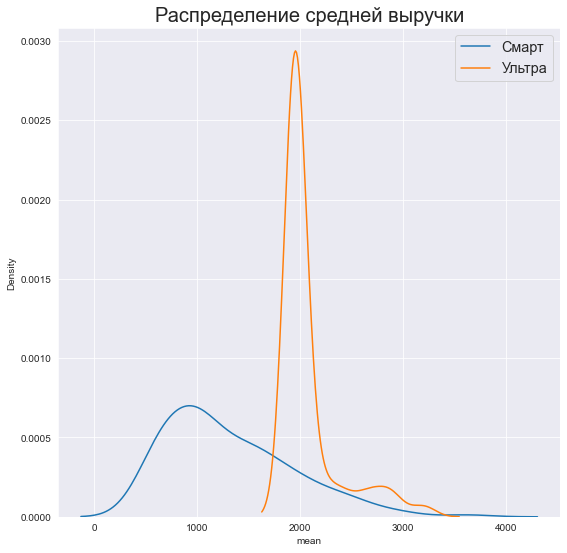

p-value = 1.5239894775879077e-33
Отвергаем нулевую гипотезу H_0.
Принимаем альтернативную H_1.
Средние выручки пользователей разных тарифов не равны.


In [38]:
alpha = 0.05

users_revenue_test1_ultra = users_revenue_test1.query("tariff == 'ultra'")
users_revenue_test1_smart = users_revenue_test1.query("tariff == 'smart'").sample(len(users_revenue_test1_ultra), random_state=45)

levene_res = levene(users_revenue_test1_ultra['mean'], users_revenue_test1_smart['mean'])
print(f"p-value = {levene_res.pvalue}")
if levene_res.pvalue < alpha:
    print('Согласно тесту Левене дисперсии выборок не равны')
else:
    print('Согласно тесту Левене дисперсии выборок равны')

print()

bartlett_res = bartlett(users_revenue_test1_ultra['mean'], users_revenue_test1_smart['mean'])
print(f"p-value = {bartlett_res.pvalue}")
if bartlett_res.pvalue < alpha:
    print('Согласно тесту Бартлетта дисперсии выборок не равны')
else:
    print('Согласно тесту Бартлетта дисперсии выборок равны')

sns.kdeplot(users_revenue_test1_smart['mean'])
sns.kdeplot(users_revenue_test1_ultra['mean'])
plt.legend(['Смарт', 'Ультра'], fontsize='x-large')
plt.title('Распределение средней выручки', fontsize=20)
plt.show()

res = ttest_ind(users_revenue_test1_smart['mean'], users_revenue_test1_ultra['mean'])
print(f"p-value = {res.pvalue}")
if res.pvalue < alpha:
    print("Отвергаем нулевую гипотезу H_0.")
    print("Принимаем альтернативную H_1.")
    print("Средние выручки пользователей разных тарифов не равны.")
else:
    print("Не отвергаем нулевую гипотезу H_0.")
    print("Средние выручки пользователей разных тарифов равны.")

Проверим, будут ли равны дисперсии выборок без уравнивания их по размеру.

In [39]:
users_revenue_test1_ultra = users_revenue_test1.query("tariff == 'ultra'")
users_revenue_test1_smart = users_revenue_test1.query("tariff == 'smart'")

levene_res = levene(users_revenue_test1_ultra['mean'], users_revenue_test1_smart['mean'])
print(f"p-value = {levene_res.pvalue}")
if levene_res.pvalue < alpha:
    print('Согласно тесту Левене дисперсии выборок не равны')
else:
    print('Согласно тесту Левене дисперсии выборок равны')

print()

bartlett_res = bartlett(users_revenue_test1_ultra['mean'], users_revenue_test1_smart['mean'])
print(f"p-value = {bartlett_res.pvalue}")
if bartlett_res.pvalue < alpha:
    print('Согласно тесту Бартлетта дисперсии выборок не равны')
else:
    print('Согласно тесту Бартлетта дисперсии выборок равны')

p-value = 3.2260285064426927e-19
Согласно тесту Левене дисперсии выборок не равны

p-value = 7.070507011382885e-21
Согласно тесту Бартлетта дисперсии выборок не равны


## Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [40]:
users_revenue_test2 = users[['user_id', 'reg_month', 'city']].merge(users_revenue, on='user_id', how='left')
users_revenue_test2['mean'] = users_revenue_test2.apply(lambda x: x.iloc[x['reg_month'].month + 3:].mean(), axis=1)

users_revenue_test2.head(2)

,user_id,reg_month,city,tariff,1,2,3,4,5,6,7,8,9,10,11,12,mean
0,1000,2018-05-01,Краснодар,ultra,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,2018-11-01,Москва,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1150.0,550.0,850.0


p-value = 0.6939963961267703
Согласно тесту Левене дисперсии выборок равны

p-value = 0.3407041450955163
Согласно тесту Бартлетта дисперсии выборок равны


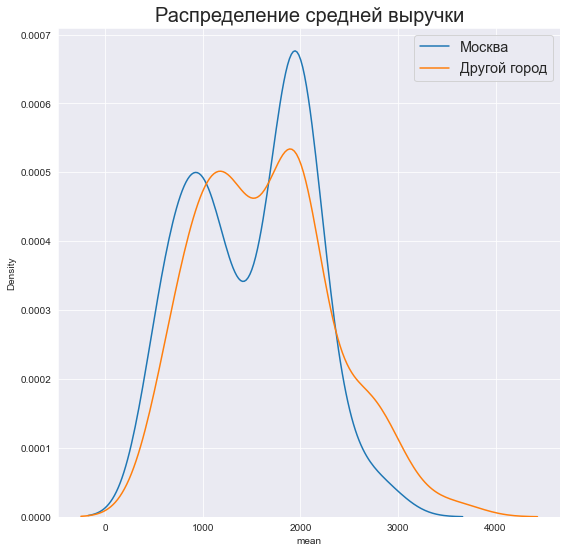

In [41]:
users_revenue_test2_msc = users_revenue_test2.query("city == 'Москва'")
users_revenue_test2_other = users_revenue_test2.query("city != 'Москва'").sample(len(users_revenue_test2_msc), random_state=45)

levene_res = levene(users_revenue_test2_msc['mean'], users_revenue_test2_other['mean'])
print(f"p-value = {levene_res.pvalue}")
if levene_res.pvalue < alpha:
    print('Согласно тесту Левене дисперсии выборок не равны')
else:
    print('Согласно тесту Левене дисперсии выборок равны')

print()

bartlett_res = bartlett(users_revenue_test2_msc['mean'], users_revenue_test2_other['mean'])
print(f"p-value = {bartlett_res.pvalue}")
if bartlett_res.pvalue < alpha:
    print('Согласно тесту Бартлетта дисперсии выборок не равны')
else:
    print('Согласно тесту Бартлетта дисперсии выборок равны')

sns.kdeplot(users_revenue_test2_msc['mean'])
sns.kdeplot(users_revenue_test2_other['mean'])
plt.legend(['Москва', 'Другой город'], fontsize='x-large')
plt.title('Распределение средней выручки', fontsize=20)
plt.show()

Перед нами сумма двух нормальных распределений: пользователи тарифа "Ультра" и тарифа "Смарт". Уже доказано, что средняя выручка по этим тарифам не равна между собой. Поэтому необходимо разделить каждую выборку на две и протестировать каждую по отдельности.

Тариф Ультра:
p-value = 0.19180349453264725
Согласно тесту Левене дисперсии выборок равны

Тариф Ультра:
p-value = 0.0007020802994437141
Согласно тесту Бартлетта дисперсии выборок не равны

Тариф Смарт:
p-value = 0.7759985407012785
Согласно тесту Левене дисперсии выборок равны

Тариф Смарт:
p-value = 0.26713449284382074
Согласно тесту Бартлетта дисперсии выборок равны

Размеры выборок:
Москва, Ультра = 32; Другой город, Ультра = 33.
Москва, Смарт = 67; Другой город, Смарт = 66.


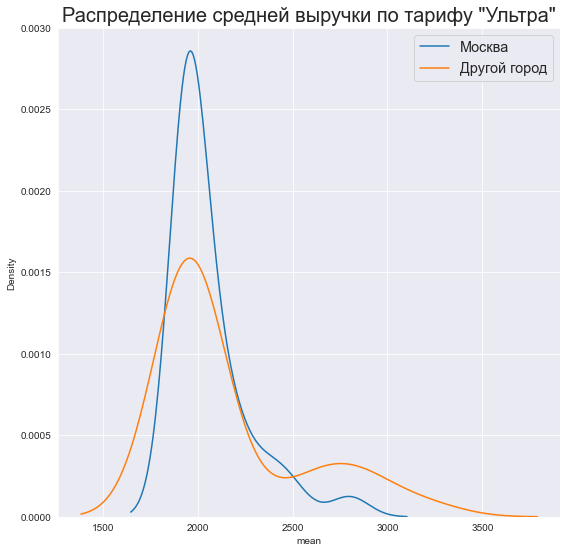

In [42]:
users_revenue_test2_msc_ultra = users_revenue_test2_msc.query("tariff == 'ultra'")
users_revenue_test2_msc_smart = users_revenue_test2_msc.query("tariff == 'smart'")

users_revenue_test2_other_ultra = users_revenue_test2_other.query("tariff == 'ultra'")
users_revenue_test2_other_smart = users_revenue_test2_other.query("tariff == 'smart'")

levene_res = levene(users_revenue_test2_msc_ultra['mean'], users_revenue_test2_other_ultra['mean'])
print('Тариф Ультра:')
print(f"p-value = {levene_res.pvalue}")
if levene_res.pvalue < alpha:
    print('Согласно тесту Левене дисперсии выборок не равны')
else:
    print('Согласно тесту Левене дисперсии выборок равны')

print()

bartlett_res = bartlett(users_revenue_test2_msc_ultra['mean'], users_revenue_test2_other_ultra['mean'])
print('Тариф Ультра:')
print(f"p-value = {bartlett_res.pvalue}")
if bartlett_res.pvalue < alpha:
    print('Согласно тесту Бартлетта дисперсии выборок не равны')
else:
    print('Согласно тесту Бартлетта дисперсии выборок равны')

print()
levene_res = levene(users_revenue_test2_msc_smart['mean'], users_revenue_test2_other_smart['mean'])
print('Тариф Смарт:')
print(f"p-value = {levene_res.pvalue}")
if levene_res.pvalue < alpha:
    print('Согласно тесту Левене дисперсии выборок не равны')
else:
    print('Согласно тесту Левене дисперсии выборок равны')

print()

bartlett_res = bartlett(users_revenue_test2_msc_smart['mean'], users_revenue_test2_other_smart['mean'])
print('Тариф Смарт:')
print(f"p-value = {bartlett_res.pvalue}")
if bartlett_res.pvalue < alpha:
    print('Согласно тесту Бартлетта дисперсии выборок не равны')
else:
    print('Согласно тесту Бартлетта дисперсии выборок равны')

print()

print(f"Размеры выборок:\n"
      f"Москва, Ультра = {users_revenue_test2_msc_ultra.shape[0]}; "
      f"Другой город, Ультра = {users_revenue_test2_other_ultra.shape[0]}.\n"
      f"Москва, Смарт = {users_revenue_test2_msc_smart.shape[0]}; "
      f"Другой город, Смарт = {users_revenue_test2_other_smart.shape[0]}.")

sns.kdeplot(users_revenue_test2_msc_ultra['mean'])
sns.kdeplot(users_revenue_test2_other_ultra['mean'])
plt.legend(['Москва', 'Другой город'], fontsize='x-large')
plt.title('Распределение средней выручки по тарифу "Ультра"', fontsize=20)
plt.show()

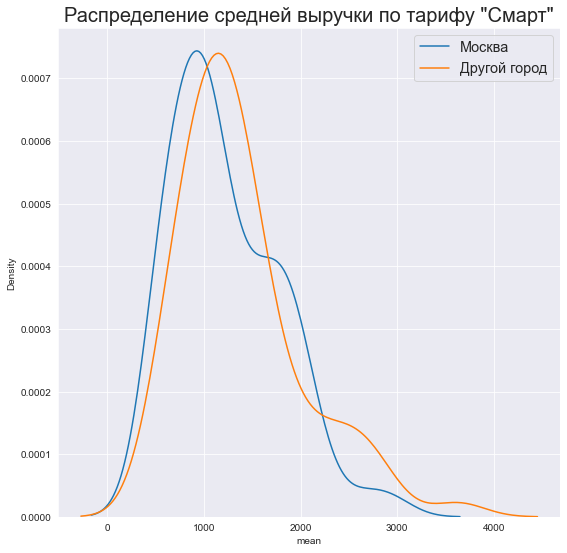

In [43]:
sns.kdeplot(users_revenue_test2_msc_smart['mean'])
sns.kdeplot(users_revenue_test2_other_smart['mean'])
plt.legend(['Москва', 'Другой город'], fontsize='x-large')
plt.title('Распределение средней выручки по тарифу "Смарт"', fontsize=20)
plt.show()

Эти распределения больше напоминают нормальные. В каждой выборке больше 30 объектов. Теперь можно проводить тесты.
Сформулируем гипотезы:
H_0: Средние выручки пользователей тарифа Ультра в Москве и в других городах равны mu_1 == mu_2
H_1: Средние выручки пользователей тарифа Ультра в Москве и в других городах ***не*** равны mu_1 != mu_2

Аналогичные гипотезы для тарифа Смарт:
H_0: Средние выручки пользователей тарифа Смарт в Москве и в других городах равны mu_1 == mu_2
H_1: Средние выручки пользователей тарифа Смарт в Москве и в других городах ***не*** равны mu_1 != mu_2

Пороговое значение alpha примем равным 5%.

In [44]:
alpha = 0.05

res_1 = ttest_ind(users_revenue_test2_msc_ultra['mean'], users_revenue_test2_other_ultra['mean'])
print(f"Тариф Ультра: p-value = {res_1.pvalue}")

res_2 = ttest_ind(users_revenue_test2_msc_smart['mean'], users_revenue_test2_other_smart['mean'])
print(f"Тариф Смарт: p-value = {res_2.pvalue}")

print()
if res_1.pvalue < alpha:
    print("Для пользователей тарифа Ультра отвергаем нулевую гипотезу H_0.")
    print("Принимаем альтернативную H_1.")
    print("Средние выручки пользователей тарифа Ультра в Москве и в других городах не равны.")
else:
    print("Не отвергаем нулевую гипотезу H_0.")
    print("Средние выручки пользователей тарифа Ультра в Москве и в других городах равны.")
print()

if res_2.pvalue < alpha:
    print("Для пользователей тарифа Смарт отвергаем нулевую гипотезу H_0.")
    print("Принимаем альтернативную H_1.")
    print("Средние выручки пользователей тарифа Смарт в Москве и в других городах не равны.")
else:
    print("Не отвергаем нулевую гипотезу H_0.")
    print("Средние выручки пользователей тарифа Смарт в Москве и в других городах равны.")

Тариф Ультра: p-value = 0.19180349453264817
Тариф Смарт: p-value = 0.14373305781652393

Не отвергаем нулевую гипотезу H_0.
Средние выручки пользователей тарифа Ультра в Москве и в других городах равны.

Не отвергаем нулевую гипотезу H_0.
Средние выручки пользователей тарифа Смарт в Москве и в других городах равны.


**ВЫВОДЫ:**
1) Средняя выручка для разных тарифов ***не равна*** между собой.
2) Средняя выручка для Москвы и других городов ***равна*** между собой. Причем вне зависимости от тарифа.


# Шаг 5. Напишите общий вывод

**ИНТЕРЕСНЫЕ НАБЛЮДЕНИЯ:**
1) Существуют абоненты, которые не совершили ни одного звонка за весь год;
2) Также существуют пользователи, которые не используют интернет;
3) Достаточно много пользователей вообще не отправляют смс;

**ВЫВОДЫ:**
1) За рамки тарифа Smart по количеству звонков выходят 71,4% пользователей, по количеству СМС - около 25%, по интренет-трафику - более 60%.
2) Пользователи тарифа Ultra обычно не выходят за лимит по звонкам и СМС. Около 10% из них тратят больше трафика, чем предоставляется в пакете услуг по абонентской плате.
3) Средние выручки пользователей разных тарифов не равны.
4) Средняя выручка пользователя не зависит от города.

Для ответа на глобальный вопрос исследования: "какой тариф приносит больше денег?", введем и рассчитаем следующую метрику.
Усредним помесячную выручку для каждого клиента, затем усредним среднюю выручку по всем клиентам одного тарифа, затем умножим это "двойное" среднее на количество абонентов каждого тарифа.
Таким образом, если предоставленная выборка отражает реальное соотношение клиентов каждого тарифа, найденное число будет отражать реальную выручку с клиентов каждого тарифа.

In [45]:
users_revenue = users[['user_id', 'reg_month']].merge(users_revenue, on='user_id', how='left')
users_revenue['mean'] = users_revenue.apply(lambda x: x.iloc[x['reg_month'].month + 2:].mean(), axis=1)

a = users_revenue.query('tariff == "ultra"')['mean'].mean() * users_revenue.query('tariff == "ultra"').shape[0]
b = users_revenue.query('tariff == "smart"')['mean'].mean() * users_revenue.query('tariff == "smart"').shape[0]

print(f'Пользователи тарифа Ультра приносят {a:.2} у.е.')
print(f'Пользователи тарифа Смарт приносят {b:.2} у.е.')

Пользователи тарифа Ультра приносят 3.1e+05 у.е.
Пользователи тарифа Смарт приносят 4.6e+05 у.е.


**ВЫВОД:**
Пользователи тарифа Смарт суммарно приносят больше денег компании, но каждый отдельный пользователь тарифа Ультра в среднем приносит больше. Увеличение количества клиентов с тарифом Ультра принесет компании больше денег, поэтому я бы рекомендовал вложить бюджет в рекламную компанию тарифа Ультра.